In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5899)

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
# number of hidden layers, batch size
nh,bs = 50,512
# number of digit classes 
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
# list of callback functions
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [5]:
# specify list of number of channels for desired convolution layers
nfs = [8,16,32,64,64]

In [6]:
# construct learner and runner objects for our model
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
%time run.fit(2, learn)

train: [1.24348359375, tensor(0.5839, device='cuda:0')]
valid: [0.3462290771484375, tensor(0.8775, device='cuda:0')]
train: [0.1917094921875, tensor(0.9404, device='cuda:0')]
valid: [0.3877398681640625, tensor(0.8755, device='cuda:0')]
Wall time: 7.17 s


## Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6018)

In [8]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect??
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [9]:
# refactor conv_layer to include BatchNorm option
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [10]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [11]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.2616521875, tensor(0.9187, device='cuda:0')]
valid: [0.230547314453125, tensor(0.9235, device='cuda:0')]


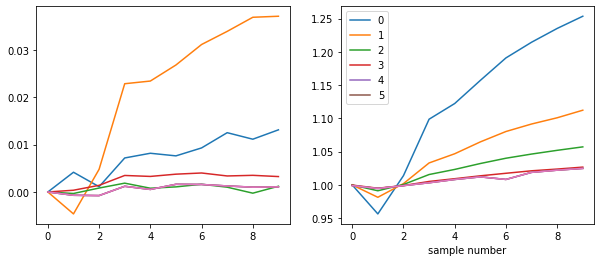

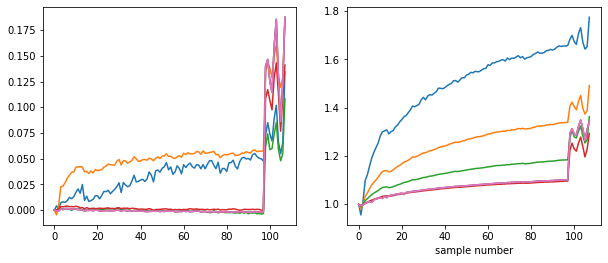

In [12]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        plt.xlabel('sample number')
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        plt.xlabel('sample number')


In [13]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [14]:
%time run.fit(3, learn)

train: [0.2539842578125, tensor(0.9218, device='cuda:0')]
valid: [0.10043220825195312, tensor(0.9688, device='cuda:0')]
train: [0.084773837890625, tensor(0.9736, device='cuda:0')]
valid: [0.07340081176757812, tensor(0.9785, device='cuda:0')]
train: [0.060890146484375, tensor(0.9806, device='cuda:0')]
valid: [0.12447401123046875, tensor(0.9618, device='cuda:0')]
Wall time: 6.26 s


### Refactor `conv_layer` to include PyTorch's builtin `BatchNorm2d`

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6679)

In [15]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [16]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [17]:
%time run.fit(3, learn)

train: [0.22636919921875, tensor(0.9289, device='cuda:0')]
valid: [0.085470556640625, tensor(0.9740, device='cuda:0')]
train: [0.0603429296875, tensor(0.9815, device='cuda:0')]
valid: [0.060587286376953126, tensor(0.9817, device='cuda:0')]
train: [0.04013493896484375, tensor(0.9876, device='cuda:0')]
valid: [0.05365203857421875, tensor(0.9828, device='cuda:0')]
Wall time: 5.37 s


### With scheduler

Now let's add the usual warm-up/annealing
We'll add the scheduler callback to the callbacks list

In [18]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [19]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [20]:
run.fit(8, learn)

train: [0.25621662109375, tensor(0.9219, device='cuda:0')]
valid: [0.09941219482421874, tensor(0.9693, device='cuda:0')]
train: [0.0843308203125, tensor(0.9733, device='cuda:0')]
valid: [0.08808291015625, tensor(0.9733, device='cuda:0')]
train: [0.0552557421875, tensor(0.9821, device='cuda:0')]
valid: [0.0688747314453125, tensor(0.9796, device='cuda:0')]
train: [0.03146492919921875, tensor(0.9896, device='cuda:0')]
valid: [0.05579303588867188, tensor(0.9831, device='cuda:0')]
train: [0.01847109619140625, tensor(0.9947, device='cuda:0')]
valid: [0.04443814697265625, tensor(0.9865, device='cuda:0')]
train: [0.010815115966796875, tensor(0.9971, device='cuda:0')]
valid: [0.04624899597167969, tensor(0.9874, device='cuda:0')]
train: [0.0064928936767578126, tensor(0.9986, device='cuda:0')]
valid: [0.04275770263671875, tensor(0.9873, device='cuda:0')]
train: [0.004301276550292969, tensor(0.9995, device='cuda:0')]
valid: [0.04195233459472656, tensor(0.9874, device='cuda:0')]


## More norms

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6717)

In [21]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.)) #gamma
        self.add  = nn.Parameter(tensor(0.)) #beta

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [22]:
# layer norm
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [23]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [24]:
%time run.fit(3, learn)

train: [nan, tensor(0.1237, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
Wall time: 7.59 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7114)

In [25]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1)) # gamma
        self.adds  = nn.Parameter(torch.zeros(nf,1,1)) # beta

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [26]:
# instance norm
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [27]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [28]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
Wall time: 7.48 s


*Question*: why can't this classify anything?

### Group norm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7213)

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectors of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7304)

In [29]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [30]:
# same as above
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [31]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [32]:
%time run.fit(1, learn)

train: [2.32026171875, tensor(0.1920, device='cuda:0')]
valid: [54.00396875, tensor(0.2329, device='cuda:0')]
Wall time: 4min 10s


### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7516)

In [33]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [34]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [35]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [36]:
%time run.fit(1, learn)

train: [0.701712890625, tensor(0.8062, device='cuda:0')]
valid: [0.252750634765625, tensor(0.9431, device='cuda:0')]
Wall time: 12min 10s


This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=8068)

In [37]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [38]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [39]:
%time run.fit(1, learn)

train: [0.16414193359375, tensor(0.9481, device='cuda:0')]
valid: [0.07377156982421874, tensor(0.9820, device='cuda:0')]
Wall time: 46.9 s


## Export

In [ ]:
nb_auto_export()